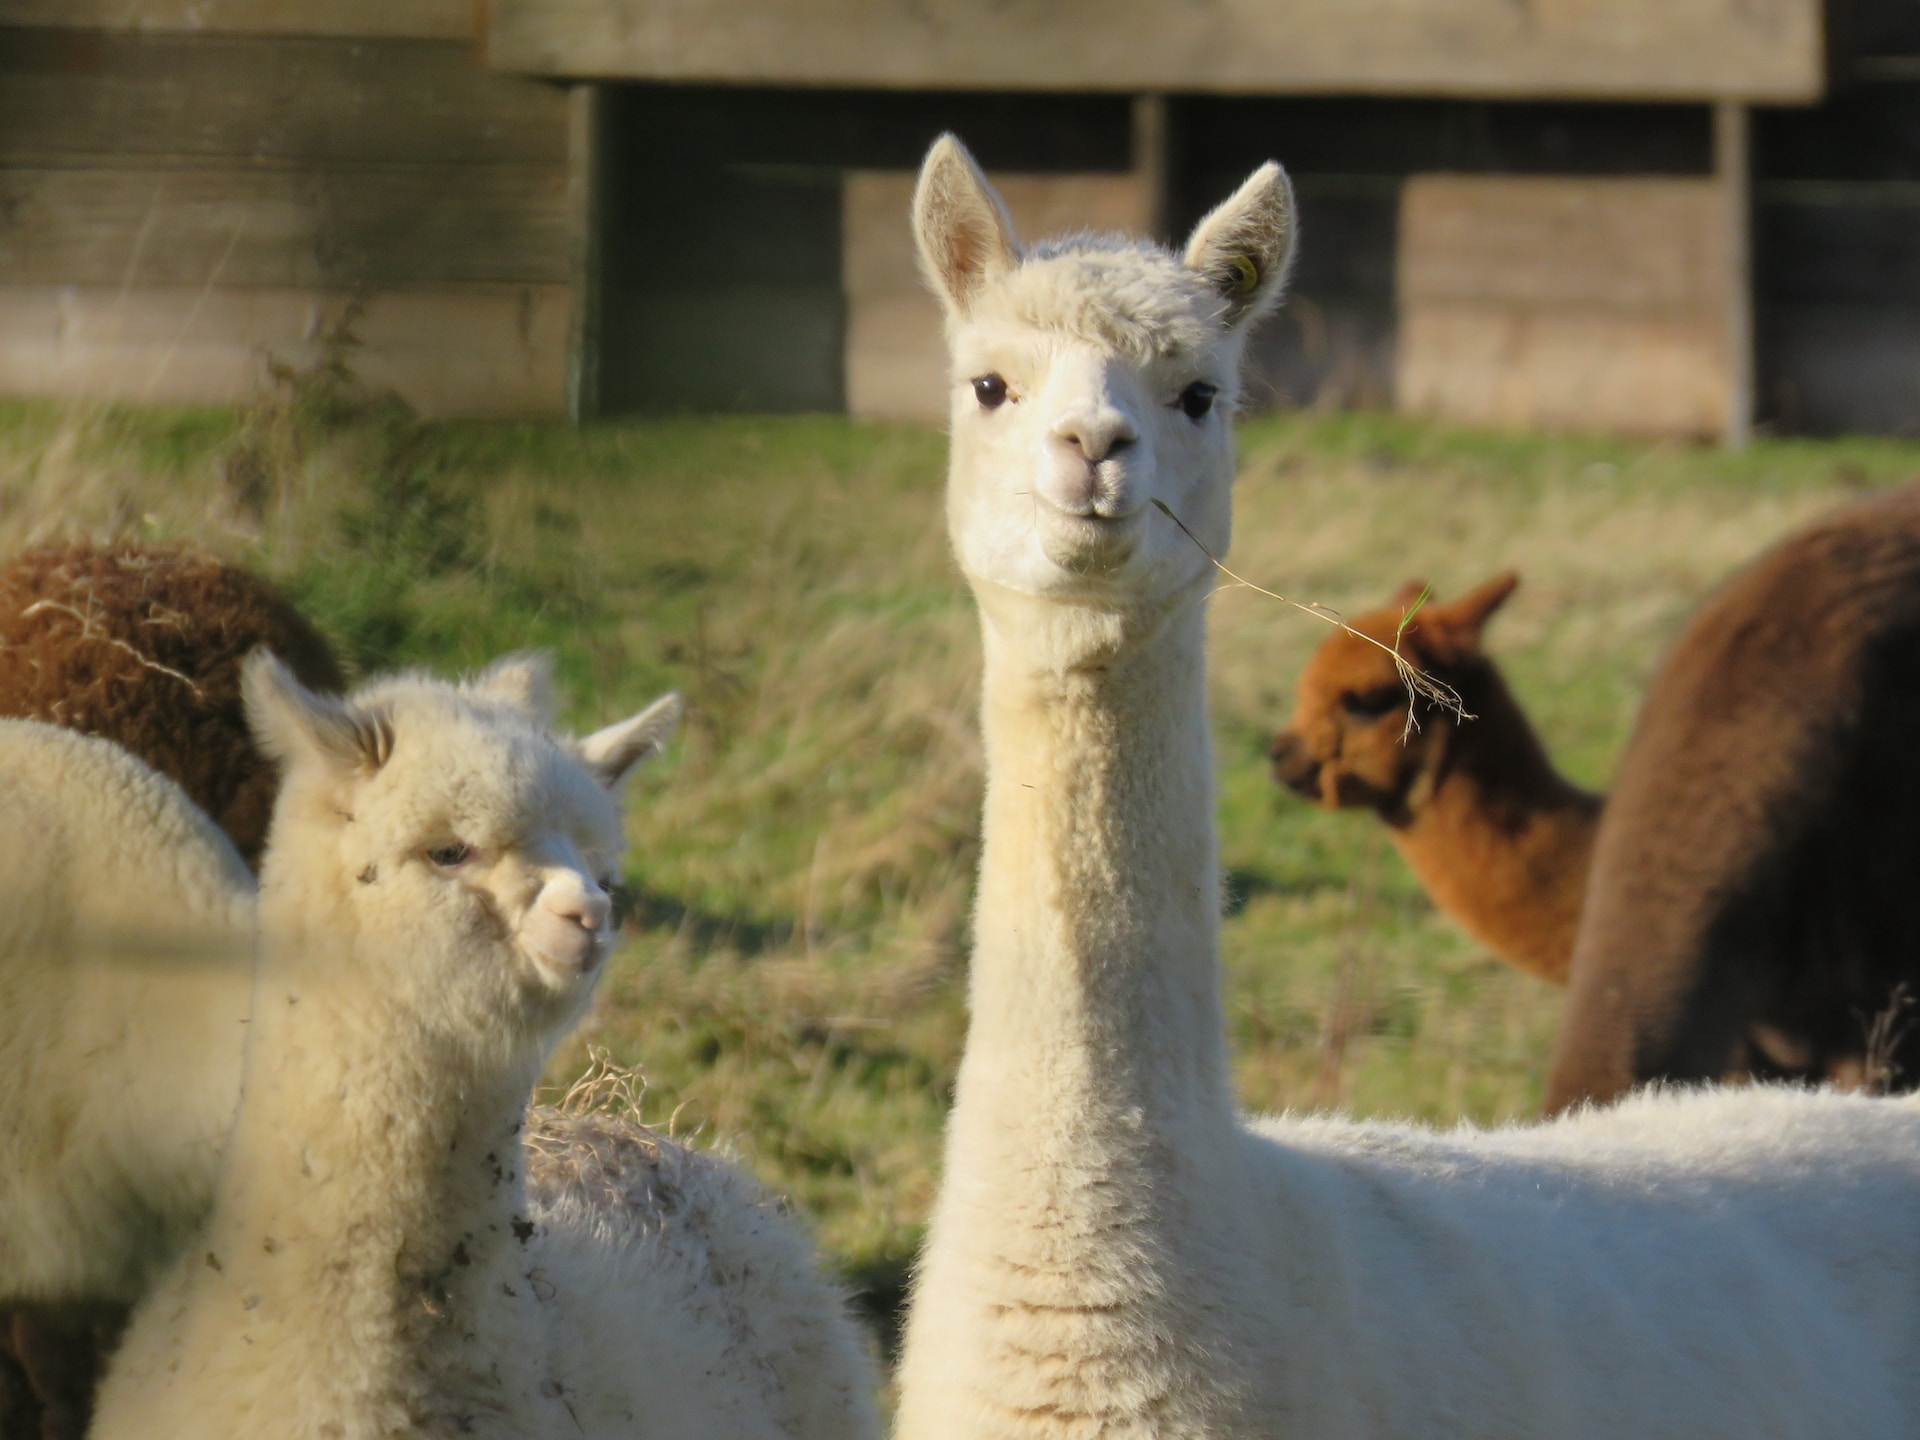
<div style="text-align: right; font-size: 10px; color: grey; margin-bottom: 2em;">Source: Photo by <a style="color: grey;" href="https://unsplash.com/@chris23?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Chris</a> on <a  style="color: grey;" href="https://unsplash.com/photos/ZhF-9SKetvs?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a></div>

In order to get the best results from Large Language Models (LLMs), prompts should be optimized to tell LLMs what to do and how to do it.
One important consideration is that they should follow the prompt template that was used during the training of a model. So we need to figure out what is Llama 2's prompt template before we can use it effectively.

## Llama 2's prompt template

How Llama 2 constructs its prompts can be found in its
<a href="https://github.com/facebookresearch/llama/blob/main/llama/generation.py#L213" target="_blank">`chat_completion`</a> function in the source code. Depending on whether it's a single turn or multi-turn chat, a prompt will have the following format.

A single turn prompt will look like this,
```
<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

{user_message} [/INST]
```
and a multi-turn prompt will look like this,
```
<s>[INST] <<SYS>>
{system_prompt}
<</SYS>>

{user_message_1} [/INST] {model_output_1} </s>\
<s>[INST] {user_message_2} [/INST] {model_output_2} </s>\
<s>[INST] {user_message_3} [/INST]
```

Here are special tokens and their meaning:

- `<s>`, `</s>`: the `bos` and `eos` tokens.
- `[INST]`, `[/INST]`: the beginning and end of the instructions for the model.
- `<<SYS>>`, `<</SYS>>`: the beginning and end of the system prompt.\
- `{system_prompt}`, `{user_message}`, `{model_output}`: placeholders for system prompt, user inputs and model outputs, respectively.

According to the <a href="https://github.com/facebookresearch/llama/blob/main/llama/generation.py#L46" target="_blank">source code</a>, the default system prompt is:

>You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.
>
>If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.


## A function for creating prompts

By going through the 
<a href="https://github.com/facebookresearch/llama/blob/main/llama/generation.py#L213" target="_blank">`chat_completion`</a> function, we can define a prompt construction function for Llama 2,

In [1]:
B_INST, E_INST = "[INST]", "[/INST]"
B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"
BOS, EOS = "<s>", "</s>"

DEFAULT_SYSTEM_PROMPT = """\
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information."""

def construct_llama2_prompt(dialog: list[dict]) -> str:
    if dialog[0]['role'] != 'system':
        # insert the default system prompt as the first message
        dialog = [{'role': 'system', 'content': DEFAULT_SYSTEM_PROMPT}] + dialog

    # merge the first 2 messages
    dialog = [{'role': dialog[1]['role'],
               'content': B_SYS + dialog[0]['content'] + E_SYS + dialog[1]['content']}
             ] + dialog[2:]

    # construct prompt using chat history
    prompt_buffer = [
        f'{BOS}{B_INST} {(prompt["content"]).strip()} {E_INST} {(answer["content"]).strip()} {EOS}' 
         for prompt, answer in zip(dialog[::2], dialog[1::2])
        ]

    if len(dialog) % 2 != 0:
        # add the last message (the current user input)
        prompt_buffer += [f'{BOS}{B_INST} {(dialog[-1]["content"]).strip()} {E_INST}']

    return ''.join(prompt_buffer)

We also create a utility function to retrieve answer from model's outputs,

In [2]:
def extract_answer(model_outputs):
    return model_outputs[0]['generated_text'].split('[/INST]')[-1].strip()

Now let's try to chat with the [Llama-2-7b-chat](https://huggingface.co/meta-llama/Llama-2-7b-chat-hf) model

## Chat with Llama 2
### load the model
We'll use `transformers` pipeline to load the model,

In [ ]:
import torch
from transformers import pipeline
from transformers import GenerationConfig

checkpoint = 'meta-llama/Llama-2-7b-chat-hf'

gen_config = GenerationConfig.from_pretrained(checkpoint)
gen_config.max_new_tokens = 4096

pipe = pipeline(task="text-generation",
                model=checkpoint,
                torch_dtype=torch.float16,
                generation_config=gen_config,
                device_map='auto',
)

### chat with the model

Here is how the prompt of a single turn dialog looks like,

In [10]:
dialog = [{'role': 'user', 'content': "Hello, how are you?"}]
prompt = construct_llama2_prompt(dialog)
print(prompt)

<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Hello, how are you? [/INST]


Send the prompt to the model,

In [11]:
outputs = pipe(prompt)
answer = extract_answer(outputs)
print(answer)

Hello! I'm just an AI, I don't have personal feelings or emotions, but I'm here to help you with any questions or concerns you may have. How can I assist you today? Please keep in mind that I'm here to provide helpful and respectful responses, and I will always do my best to ensure that my answers are safe, socially unbiased, and positive in nature. If a question doesn't make sense or is not factually coherent, I will explain why instead of answering something not correct. If I don't know the answer to a question, I will not share false information. Is there anything else I can help you with?


Keep chatting and the following are prompts of multi-turn dialog,

In [12]:
dialog += [
    {'role': 'assistant', 'content': answer},
    {'role': 'user', 'content': "Can you tell me a science joke?"}
]

prompt = construct_llama2_prompt(dialog)
print(prompt)

<s>[INST] <<SYS>>
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.
<</SYS>>

Hello, how are you? [/INST] Hello! I'm just an AI, I don't have personal feelings or emotions, but I'm here to help you with any questions or concerns you may have. How can I assist you today? Please keep in mind that I'm here to provide helpful and respectful responses, and I will always do my best to ensure that my answers are safe, socially unbiased, and positive in nature. If a question doesn't make sense or is not factually coherent, I will explain why in

In [13]:
outputs = pipe(prompt)
answer = extract_answer(outputs)
print(answer)

Of course! Here's a science joke for you:
Why did the physicist break up with his girlfriend?
She was always gravitating towards him, but he needed some space!
I hope you found that joke amusing! Do you have any other questions or topics you'd like to discuss?


## What if we don't follow the model's prompt template?

We can do a quick test.

In [14]:
question = 'How to make pizza?'

### Not following the template

In [15]:
output1 = pipe(question)
print(output1[0]['generated_text'])

How to make pizza?

To make pizza, you will need the following ingredients:

* Pizza dough (homemade or store-bought)
* Pizza sauce
* Mozzarella cheese (shredded or sliced)
* Toppings of your choice (e.g. pepperoni, sausage, mushrooms, onions, bell peppers)

Here is a basic recipe for making pizza at home:

1. Preheat your oven to 450-500°F (230-260°C).
2. If using homemade pizza dough, let it rise for 1-2 hours until it is puffy and doubled in size. If using store-bought dough, follow the package instructions for thawing and rising.
3. Roll out the pizza dough on a floured surface to your desired thickness. Transfer the dough to a pizza pan or baking sheet.
4. Spread the pizza sauce over the dough, leaving a small border around the edges.
5. Sprinkle the shredded mozzarella cheese over the sauce.
6. Add your desired toppings, such as pepperoni, sausage, mushrooms, onions, and bell peppers.
7. Bake the pizza in the preheated oven for 10-15 minutes, or until the crust is golden brown an

The answer is not bad. But let's see how the model will respond if we follow its prompt template.

### Following the template

In [16]:
dialog = [{'role': 'user', 'content': 'How to make pizza?'}]
output2 = pipe(construct_llama2_prompt(dialog))
print(extract_answer(output2))

Great question! Making pizza can be a fun and delicious activity. Here's a basic recipe for making pizza at home:
Ingredients:
* 1 1/2 cups warm water
* 2 tablespoons active dry yeast
* 3 1/2 cups all-purpose flour
* 1 teaspoon salt
* 2 tablespoons olive oil
* 1 cup pizza sauce (homemade or store-bought)
* Toppings of your choice (such as cheese, vegetables, meats, etc.)
Instructions:
1. In a large mixing bowl, combine the warm water and yeast. Let it sit for 5-10 minutes until the yeast becomes frothy.
2. Add the flour, salt, and olive oil to the bowl. Mix until a dough forms.
3. Knead the dough on a floured surface for 5-10 minutes until it becomes smooth and elastic.
4. Place the dough in a lightly oiled bowl, cover it with plastic wrap, and let it rise in a warm, draft-free place for 1-2 hours until it has doubled in size.
5. Preheat your oven to 450-500°F (230-260°C).
6. Punch down the dough and divide it into as many portions as you want to make individual pizzas.
7. Roll out eac